In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import os

data_dir = "./"   

# Check available files
files = os.listdir(data_dir)
print("Available files:")
for f in files:
    if f.endswith(".xlsx"):
        print(f)


Available files:
Evaporation.xlsx
Run_Off.xlsx
Soil_Moisture.xlsx
Water_Vapour.xlsx
Temperature_Max.xlsx
Temperature_Min.xlsx
AOD.xlsx
Humidity.xlsx
Wind_Speed.xlsx
Precipitation.xlsx


In [15]:
import os
import re
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

try:
    import xgboost as xgb
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False

In [16]:

file_names = {
    'AOD': 'AOD.xlsx',
    'Evaporation': 'Evaporation.xlsx',
    'Humidity': 'Humidity.xlsx',
    'Precipitation': 'Precipitation.xlsx',
    'Runoff': 'Run_Off.xlsx',
    'Soil_Moisture': 'Soil_Moisture.xlsx',
    'Temp_Max': 'Temperature_Max.xlsx',
    'Temp_Min': 'Temperature_Min.xlsx',
    'Water_Vapour': 'Water_Vapour.xlsx',
    'Wind_Speed': 'Wind_Speed.xlsx'
}

def load_data(var, filename):
    path = os.path.join(data_dir, filename)
    if not os.path.exists(path):
        print(f"❌ {filename} not found")
        return None

   
    df = pd.read_excel(path, header=0)

   
    df.columns = [str(c).strip().lower() for c in df.columns]

    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    print(f"✅ Loaded {filename} | Shape = {df.shape}")
    return df


In [17]:
datasets = {var: load_data(var, fname) for var, fname in file_names.items()}


✅ Loaded AOD.xlsx | Shape = (547, 122)
✅ Loaded Evaporation.xlsx | Shape = (547, 122)
✅ Loaded Humidity.xlsx | Shape = (547, 122)
✅ Loaded Precipitation.xlsx | Shape = (541, 122)
✅ Loaded Run_Off.xlsx | Shape = (547, 122)
✅ Loaded Soil_Moisture.xlsx | Shape = (547, 122)
✅ Loaded Temperature_Max.xlsx | Shape = (547, 122)
✅ Loaded Temperature_Min.xlsx | Shape = (547, 122)
✅ Loaded Water_Vapour.xlsx | Shape = (547, 122)
✅ Loaded Wind_Speed.xlsx | Shape = (547, 122)


In [18]:
for var, df in datasets.items():
    if df is not None:
        print(f"\n🔹 {var} — Columns: {list(df.columns)}")
        print(df.head())



🔹 AOD — Columns: ['unit', 'lat', '23.25', '23.25.1', '23.25.2', '23.25.3', '23.25.4', '23.25.5', '23.25.6', '23.25.7', '23.25.8', '23.25.9', '23.25.10', '23.25.11', '23.75', '23.75.1', '23.75.2', '23.75.3', '23.75.4', '23.75.5', '23.75.6', '23.75.7', '23.75.8', '23.75.9', '23.75.10', '23.75.11', '24.25', '24.25.1', '24.25.2', '24.25.3', '24.25.4', '24.25.5', '24.25.6', '24.25.7', '24.25.8', '24.25.9', '24.25.10', '24.25.11', '24.75', '24.75.1', '24.75.2', '24.75.3', '24.75.4', '24.75.5', '24.75.6', '24.75.7', '24.75.8', '24.75.9', '24.75.10', '24.75.11', '25.25', '25.25.1', '25.25.2', '25.25.3', '25.25.4', '25.25.5', '25.25.6', '25.25.7', '25.25.8', '25.25.9', '25.25.10', '25.25.11', '25.75', '25.75.1', '25.75.2', '25.75.3', '25.75.4', '25.75.5', '25.75.6', '25.75.7', '25.75.8', '25.75.9', '25.75.10', '25.75.11', '26.25', '26.25.1', '26.25.2', '26.25.3', '26.25.4', '26.25.5', '26.25.6', '26.25.7', '26.25.8', '26.25.9', '26.25.10', '26.25.11', '26.75', '26.75.1', '26.75.2', '26.75.3', 

In [19]:
import numpy as np
import pandas as pd
import re

def reshape_grid(df, var_name):
    
    if 'lon' not in df.columns:
        df = df.reset_index().rename(columns={'index': 'lon'})
    
    df_long = df.melt(id_vars='lon', var_name='lat', value_name=var_name)
    
    def clean_numeric(x):
        match = re.match(r'^-?\d+(\.\d+)?', str(x))
        if match:
            return float(match.group())
        return None  
    
    df_long['lat'] = df_long['lat'].apply(clean_numeric)
    df_long['lon'] = df_long['lon'].apply(clean_numeric)
    
    df_long = df_long.dropna(subset=['lat', 'lon'])
    
    return df_long



precip = datasets['Precipitation']
precip_long = reshape_grid(precip, 'Precipitation')
print(precip_long.head())
print("Shape:", precip_long.shape)


      lon    lat Precipitation
1082  0.0  23.25         69.75
1083  1.0  23.25        0.1354
1084  2.0  23.25           0.0
1085  3.0  23.25           0.0
1086  4.0  23.25           0.0
Shape: (64920, 3)


In [20]:
cleaned_dfs = []  # ✅ Initialize before the loop

for var, df in datasets.items():
    if df is None:
        continue

    # Standardize lat/lon column names
    for col in df.columns:
        if 'lat' in col.lower():
            df.rename(columns={col: 'lat'}, inplace=True)
        if 'lon' in col.lower():
            df.rename(columns={col: 'lon'}, inplace=True)

    # Create date column if missing
    if 'date' not in df.columns:
        print(f"⚠️  {var} has no 'date' column — creating placeholder index.")
        df['date'] = pd.date_range(start='1980-01-01', periods=len(df), freq='ME')  # fixed freq warning

    # Fill missing lat/lon
    if 'lat' not in df.columns:
        df['lat'] = 0.0
    if 'lon' not in df.columns:
        df['lon'] = 0.0

    # 👉 Add prefix to avoid duplicate column names
    df = df.add_prefix(f"{var}_")

    # Restore common merge keys
    df.rename(columns={f"{var}_date": "date", f"{var}_lat": "lat", f"{var}_lon": "lon"}, inplace=True)

    cleaned_dfs.append(df)  # ✅ Now this works

from functools import reduce

merged = reduce(lambda left, right: pd.merge(left, right, on=['date', 'lat', 'lon'], how='outer'), cleaned_dfs)
print("✅ Merged data shape:", merged.shape)
print("Merged columns:", list(merged.columns)[:10])




⚠️  AOD has no 'date' column — creating placeholder index.
⚠️  Evaporation has no 'date' column — creating placeholder index.
⚠️  Humidity has no 'date' column — creating placeholder index.
⚠️  Precipitation has no 'date' column — creating placeholder index.
⚠️  Runoff has no 'date' column — creating placeholder index.
⚠️  Soil_Moisture has no 'date' column — creating placeholder index.
⚠️  Temp_Max has no 'date' column — creating placeholder index.
⚠️  Temp_Min has no 'date' column — creating placeholder index.
⚠️  Water_Vapour has no 'date' column — creating placeholder index.
⚠️  Wind_Speed has no 'date' column — creating placeholder index.
✅ Merged data shape: (547, 1213)
Merged columns: ['AOD_unit', 'lat', 'AOD_23.25', 'AOD_23.25.1', 'AOD_23.25.2', 'AOD_23.25.3', 'AOD_23.25.4', 'AOD_23.25.5', 'AOD_23.25.6', 'AOD_23.25.7']


In [21]:

print(merged.isnull().sum())


merged = merged.sort_values('date')
merged = merged.fillna(method='ffill').fillna(method='bfill')


print("Missing values after fill:")
print(merged.isnull().sum())


AOD_unit               546
lat                      0
AOD_23.25                0
AOD_23.25.1              0
AOD_23.25.2              0
                      ... 
Wind_Speed_27.75.7       0
Wind_Speed_27.75.8       0
Wind_Speed_27.75.9       0
Wind_Speed_27.75.10      0
Wind_Speed_27.75.11      0
Length: 1213, dtype: int64
Missing values after fill:
AOD_unit               0
lat                    0
AOD_23.25              0
AOD_23.25.1            0
AOD_23.25.2            0
                      ..
Wind_Speed_27.75.7     0
Wind_Speed_27.75.8     0
Wind_Speed_27.75.9     0
Wind_Speed_27.75.10    0
Wind_Speed_27.75.11    0
Length: 1213, dtype: int64


/var/folders/jd/j5rtjghd2ql9js6pwlty00040000gn/T/ipykernel_29623/3796763519.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = merged.fillna(method='ffill').fillna(method='bfill')


In [22]:

print(merged.describe())


print("Date range:", merged['date'].min(), "→", merged['date'].max())


        AOD_23.25  AOD_23.25.1  AOD_23.25.2  AOD_23.25.3  AOD_23.25.4  \
count  547.000000   547.000000   547.000000   547.000000   547.000000   
mean     0.466845     0.468024     0.468400     0.466563     0.466228   
min      0.086734     0.086013     0.083843     0.081458     0.080926   
25%      0.236935     0.241291     0.244828     0.245241     0.243990   
50%      0.319435     0.322045     0.323954     0.326805     0.327209   
75%      0.413044     0.413649     0.415068     0.412056     0.411429   
max     69.750000    70.250000    70.750000    71.250000    71.750000   
std      2.971617     2.992735     3.013934     3.035212     3.056500   

       AOD_23.25.5  AOD_23.25.6  AOD_23.25.7  AOD_23.25.8  AOD_23.25.9  ...  \
count   547.000000   547.000000   547.000000   547.000000   547.000000  ...   
mean      0.465003     0.462806     0.459083     0.452798     0.444523  ...   
min       0.080340     0.079999     0.079317     0.076818     0.072597  ...   
25%       0.242345     0.2

In [23]:
merged.to_csv("Luni_Flood_Data_Clean.csv", index=False)
print("Cleaned data saved as Luni_Flood_Data_Clean.csv")


Cleaned data saved as Luni_Flood_Data_Clean.csv


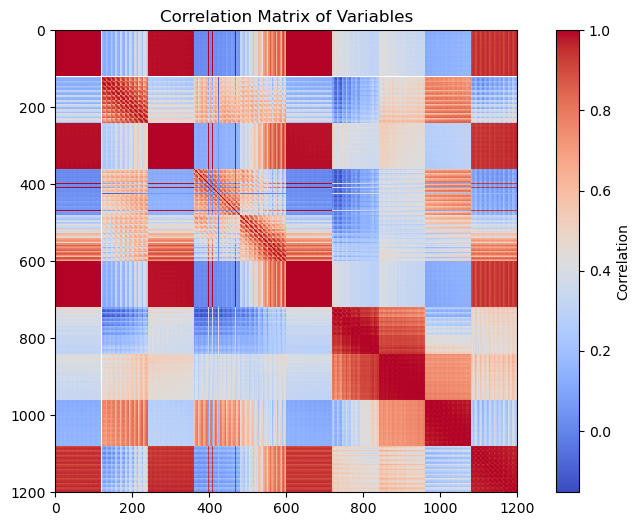

In [24]:
if 'precipitation' in merged.columns:
    plt.figure(figsize=(10,4))
    plt.plot(merged['date'], merged['precipitation'], color='blue')
    plt.title('Precipitation Over Time')
    plt.xlabel('Date')
    plt.ylabel('Precipitation')
    plt.grid(True)
    plt.show()

plt.figure(figsize=(10,6))
corr = merged.select_dtypes('number').corr()
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation')
plt.title("Correlation Matrix of Variables")
plt.show()


In [29]:
OUTPUT_DIR = Path('luni_pipeline_outputs')
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
CSV_PATH = Path('Luni_Flood_Data_Clean.csv')

In [31]:
d = pd.read_csv('Luni_Flood_Data_Clean.csv')
d.tail()

,AOD_unit,lat,AOD_23.25,AOD_23.25.1,AOD_23.25.2,AOD_23.25.3,AOD_23.25.4,AOD_23.25.5,AOD_23.25.6,AOD_23.25.7,...,Wind_Speed_27.75.2,Wind_Speed_27.75.3,Wind_Speed_27.75.4,Wind_Speed_27.75.5,Wind_Speed_27.75.6,Wind_Speed_27.75.7,Wind_Speed_27.75.8,Wind_Speed_27.75.9,Wind_Speed_27.75.10,Wind_Speed_27.75.11
542,Unitless,2025-02-01 00:00:00,0.239474,0.239707,0.237719,0.234463,0.231807,0.225507,0.219037,0.213391,...,3.986515,4.059089,4.177336,4.313220,4.428306,4.503239,4.537740,4.543709,4.526528,4.494205
543,Unitless,2025-03-01 00:00:00,0.226821,0.231878,0.236050,0.240387,0.243557,0.242592,0.240459,0.237313,...,4.830215,4.813789,4.907727,5.065229,5.218822,5.335611,5.417279,5.371098,5.323153,5.330975
544,Unitless,2025-04-01 00:00:00,0.293887,0.304906,0.315186,0.322518,0.327209,0.327472,0.327363,0.327712,...,5.001449,5.184860,5.270544,5.346889,5.434017,5.535333,5.637533,5.636790,5.626186,5.591860
545,Unitless,2025-05-01 00:00:00,0.557105,0.564973,0.574821,0.582239,0.586312,0.590301,0.594638,0.594223,...,6.609230,6.691114,6.682432,6.660380,6.618625,6.534123,6.367120,6.244669,6.173421,6.116325
546,Unitless,2025-06-01 00:00:00,0.584511,0.561236,0.546529,0.536085,0.532142,0.531963,0.527746,0.515335,...,6.821166,6.728371,6.548808,6.429262,6.355126,6.250081,5.976103,5.666416,5.455571,5.297068


In [33]:
import pandas as pd

# ==== STEP 1: Load the CSV ====
input_file = "Luni_Flood_Data_Clean.csv"
df = pd.read_csv(input_file)

print("Original shape:", df.shape)

# ==== STEP 2: Remove exact duplicate columns ====
df = df.loc[:, ~df.columns.duplicated()]

print("After removing duplicate columns:", df.shape)

# ==== STEP 3: Remove unwanted 'unit_*' columns ====
df = df.drop(columns=[col for col in df.columns if col.startswith("unit_")], errors='ignore')

print("After dropping unit columns:", df.shape)

# ==== STEP 4: Handle repeated grid columns (keep first set only) ====
# For example, columns like "23.25_x", "23.25_x.1", "23.25_x.2"...
clean_cols = []
seen = set()

for col in df.columns:
    # Strip trailing .1, .2, .3 etc.
    base = col.split('.')[0]  
    if base not in seen:
        clean_cols.append(col)
        seen.add(base)

df = df[clean_cols]

print("After keeping first occurrence of grid columns:", df.shape)

# ==== STEP 5: Save the cleaned CSV ====
output_file = "cleaned_file.csv"
df.to_csv(output_file, index=False)

print(f"✅ Cleaned file saved as: {output_file}")


Original shape: (547, 1213)
After removing duplicate columns: (547, 1213)
After dropping unit columns: (547, 1213)
After keeping first occurrence of grid columns: (547, 63)
✅ Cleaned file saved as: cleaned_file.csv


In [35]:
def read_raw_csv(path):
    return pd.read_csv(path, header=None)




def try_multiheader_parse(path, header_rows=[0,1,2]):

    try:
        df = pd.read_csv(path, header=header_rows)
        if isinstance(df.columns, pd.MultiIndex):
            cols = ["_" .join([str(c).strip() for c in col if str(c) != 'nan']) for col in df.columns.values]
            df.columns = cols
            return df
    except Exception as e:
        print('multiheader parse failed:', e)
        return None




def detect_date_column(df):
    for c in df.columns:
        low = c.lower()
        if 'date' in low or 'time' in low:
            return c
    for c in df.columns:
        try:
            parsed = pd.to_datetime(df[c], errors='coerce')
            if parsed.notna().sum() > 0.6*len(df):
                return c
        except Exception:
            pass
    return None




def coerce_datetime_index(df, date_col):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.set_index(date_col).sort_index()
    return df

In [37]:


KNOWN_VARS = [
    'precip', 'rain', 'runoff', 'soil', 'moist', 'humidity', 'aod', 'evap', 'evaporation',
    'temp_max', 'tempmin', 'temp_min', 'tmax', 'tmin', 'water_vap', 'vapour', 'wind', 'ws'
]

def map_columns_to_variables(df):
    mapping = {v: [] for v in KNOWN_VARS}
    for c in df.columns:
        low = c.lower()
        for v in KNOWN_VARS:
            if v in low:
                mapping[v].append(c)
    mapping = {k: v for k, v in mapping.items() if len(v) > 0}
    return mapping

def aggregate_to_basin(df, mapping, stats=['mean', 'median', 'max']):
    out = pd.DataFrame(index=df.index)
    for var, cols in mapping.items():
        sub = df[cols].apply(pd.to_numeric, errors='coerce')
        if 'mean' in stats:
            out[f'{var}_mean'] = sub.mean(axis=1)
        if 'median' in stats:
            out[f'{var}_median'] = sub.median(axis=1)
        if 'max' in stats:
            out[f'{var}_max'] = sub.max(axis=1)
        if 'std' in stats:
            out[f'{var}_std'] = sub.std(axis=1)
    return out


In [38]:
import pandas as pd
from pathlib import Path

OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)


def create_flood_label(df, runoff_col, percentile=0.95, lead_days=0):
    """
    Create flood labels based on chosen runoff/precipitation column.
    """
    if runoff_col not in df.columns:
        raise ValueError(
            f"Column '{runoff_col}' not found in dataframe. Available: {df.columns.tolist()}"
        )

    print(f"✅ Using column for flood label: {runoff_col}")

    # Compute threshold
    series = pd.to_numeric(df[runoff_col], errors='coerce')
    thresh = series.quantile(percentile)
    print(f"✅ Computed threshold at {percentile*100:.1f} percentile: {thresh:.4f}")

    # Create flood label
    df = df.copy()
    df['flood_label'] = (series.shift(-lead_days) >= thresh).astype(int)

    return df, runoff_col, thresh

In [39]:
import pandas as pd

def add_lag_and_rolling_features(df, vars_to_lag, lags=[1, 2, 3, 7, 14], rolling_windows=[3, 7, 14]):
    df = df.copy()
    for v in vars_to_lag:
        if v not in df.columns:
            continue
        for lag in lags:
            df[f'{v}_lag{lag}'] = df[v].shift(lag)
        for w in rolling_windows:
            df[f'{v}_roll{w}_mean'] = df[v].rolling(window=w, min_periods=1).mean()
            df[f'{v}_roll{w}_sum'] = df[v].rolling(window=w, min_periods=1).sum()
    if isinstance(df.index, pd.DatetimeIndex):
        df['month'] = df.index.month
        df['dayofyear'] = df.index.dayofyear
    return df


In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

try:
    import xgboost as xgb
    _HAS_XGB = True
except ImportError:
    _HAS_XGB = False

def train_baseline_model(df, target_col, feature_cols=None, model_type='xgboost'):
    df = df.copy()
    df = df.dropna(subset=[target_col])
    if feature_cols is None:
        feature_cols = [c for c in df.columns if c != target_col and df[c].dtype in [float, int]]
    X = df[feature_cols].astype(float).fillna(method='ffill').fillna(0)
    y = df[target_col].astype(int)
    tscv = TimeSeriesSplit(n_splits=5)
    metrics, models = [], []
    for train_idx, test_idx in tscv.split(X):
        Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]
        ytr, yte = y.iloc[train_idx], y.iloc[test_idx]
        scaler = StandardScaler()
        Xtr_s = scaler.fit_transform(Xtr)
        Xte_s = scaler.transform(Xte)
        if model_type == 'xgboost' and _HAS_XGB:
            dtrain = xgb.DMatrix(Xtr_s, label=ytr)
            dtest = xgb.DMatrix(Xte_s, label=yte)
            params = {'objective':'binary:logistic','eval_metric':'auc','use_label_encoder':False}
            bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest,'val')], verbose_eval=False)
            ypred_prob = bst.predict(dtest)
            ypred = (ypred_prob >= 0.5).astype(int)
            models.append((bst, scaler))
        else:
            clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
            clf.fit(Xtr_s, ytr)
            ypred = clf.predict(Xte_s)
            try:
                ypred_prob = clf.predict_proba(Xte_s)[:,1]
            except Exception:
                ypred_prob = ypred
            models.append((clf, scaler))
        prec, rec, f1, _ = precision_recall_fscore_support(yte, ypred, average='binary', zero_division=0)
        try:
            auc = roc_auc_score(yte, ypred_prob)
        except Exception:
            auc = np.nan
        metrics.append({'precision':prec, 'recall':rec, 'f1':f1, 'auc':auc, 'test_size':len(test_idx)})
    return models[-1], metrics, feature_cols


In [41]:
import matplotlib.pyplot as plt

def save_simple_plots(df, cols, outdir=OUTPUT_DIR):
    for c in cols:
        plt.figure(figsize=(10, 3))
        plt.plot(df.index, df[c])
        plt.title(c)
        plt.tight_layout()
        p = outdir / f'plot_{c}.png'
        plt.savefig(p)
        plt.close()


In [42]:
import pandas as pd

df = pd.read_csv("Luni_Flood_Data_Clean.csv")
print("Columns in CSV:\n", df.columns.tolist())
df.head()


Columns in CSV:
 ['AOD_unit', 'lat', 'AOD_23.25', 'AOD_23.25.1', 'AOD_23.25.2', 'AOD_23.25.3', 'AOD_23.25.4', 'AOD_23.25.5', 'AOD_23.25.6', 'AOD_23.25.7', 'AOD_23.25.8', 'AOD_23.25.9', 'AOD_23.25.10', 'AOD_23.25.11', 'AOD_23.75', 'AOD_23.75.1', 'AOD_23.75.2', 'AOD_23.75.3', 'AOD_23.75.4', 'AOD_23.75.5', 'AOD_23.75.6', 'AOD_23.75.7', 'AOD_23.75.8', 'AOD_23.75.9', 'AOD_23.75.10', 'AOD_23.75.11', 'AOD_24.25', 'AOD_24.25.1', 'AOD_24.25.2', 'AOD_24.25.3', 'AOD_24.25.4', 'AOD_24.25.5', 'AOD_24.25.6', 'AOD_24.25.7', 'AOD_24.25.8', 'AOD_24.25.9', 'AOD_24.25.10', 'AOD_24.25.11', 'AOD_24.75', 'AOD_24.75.1', 'AOD_24.75.2', 'AOD_24.75.3', 'AOD_24.75.4', 'AOD_24.75.5', 'AOD_24.75.6', 'AOD_24.75.7', 'AOD_24.75.8', 'AOD_24.75.9', 'AOD_24.75.10', 'AOD_24.75.11', 'AOD_25.25', 'AOD_25.25.1', 'AOD_25.25.2', 'AOD_25.25.3', 'AOD_25.25.4', 'AOD_25.25.5', 'AOD_25.25.6', 'AOD_25.25.7', 'AOD_25.25.8', 'AOD_25.25.9', 'AOD_25.25.10', 'AOD_25.25.11', 'AOD_25.75', 'AOD_25.75.1', 'AOD_25.75.2', 'AOD_25.75.3', 'AOD_

,AOD_unit,lat,AOD_23.25,AOD_23.25.1,AOD_23.25.2,AOD_23.25.3,AOD_23.25.4,AOD_23.25.5,AOD_23.25.6,AOD_23.25.7,...,Wind_Speed_27.75.2,Wind_Speed_27.75.3,Wind_Speed_27.75.4,Wind_Speed_27.75.5,Wind_Speed_27.75.6,Wind_Speed_27.75.7,Wind_Speed_27.75.8,Wind_Speed_27.75.9,Wind_Speed_27.75.10,Wind_Speed_27.75.11
0,Unitless,LONG,69.750000,70.250000,70.750000,71.250000,71.750000,72.250000,72.750000,73.250000,...,70.750000,71.250000,71.750000,72.250000,72.750000,73.250000,73.750000,74.250000,74.750000,75.250000
1,Unitless,1980-01-01 00:00:00,0.101193,0.100267,0.097250,0.092850,0.089899,0.087019,0.085181,0.084645,...,4.073852,4.127050,4.265364,4.401109,4.472439,4.461063,4.392245,4.364094,4.354878,4.353523
2,Unitless,1980-02-01 00:00:00,0.173471,0.170198,0.166149,0.160892,0.156851,0.151822,0.146537,0.141562,...,4.145743,4.144352,4.179108,4.296359,4.452306,4.600925,4.693969,4.686932,4.704206,4.799589
3,Unitless,1980-03-01 00:00:00,0.204825,0.206473,0.206281,0.203212,0.200819,0.196315,0.190222,0.183441,...,5.083583,5.078451,5.061188,5.039951,5.001268,4.941376,4.866212,4.824205,4.799106,4.791806
4,Unitless,1980-04-01 00:00:00,0.239276,0.244381,0.247702,0.246530,0.243878,0.237445,0.229022,0.220192,...,4.991470,5.073151,5.065643,5.047676,5.021433,5.000721,5.010974,4.979967,5.007187,5.119849


In [43]:
import pandas as pd
from pathlib import Path

# Define your output directory
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

def run_pipeline(csv_path="cleaned_file.csv", lead_days=2):
    print("🚀 Starting flood prediction pipeline...")

    # ----------------------------------------
    # Load input CSV
    df = pd.read_csv(csv_path)
    print("✅ Data loaded. Shape:", df.shape)

    # ----------------------------------------
    # Identify grid columns dynamically
    # Look for numeric-like column names that represent grid cells
    grid_cols = [c for c in df.columns if any(char.isdigit() for char in c) and '_x' in c or '.' in c]

    if not grid_cols:
        raise ValueError(
            f"❌ No grid columns detected. Available columns: {list(df.columns)[:10]}"
        )

    print(f"✅ Found {len(grid_cols)} grid columns for aggregation.")

    # ----------------------------------------
    # Aggregate — take mean across grid cells
    df['precipitation'] = df[grid_cols].mean(axis=1)
    print("✅ Created aggregated 'precipitation' column.")

    # Save intermediate aggregated data
    agg = df[['date', 'lat', 'lon', 'precipitation']]
    agg.to_csv(OUTPUT_DIR / 'aggregated_timeseries.csv', index=False)
    print("✅ Aggregated data saved.")

    # ----------------------------------------
    # Create labels (assuming you already defined this function)
    df_with_label, runoff_col, thresh = create_flood_label(
        agg,
        runoff_col='precipitation',
        percentile=0.95,
        lead_days=lead_days
    )

    df_with_label.to_csv(OUTPUT_DIR / 'labeled_timeseries.csv', index=False)
    print(f"✅ Labeled data saved. Column used: {runoff_col}, threshold={thresh:.4f}")

    print(f"🎯 Pipeline finished. Outputs saved to {OUTPUT_DIR.resolve()}")


if __name__ == "__main__":
    run_pipeline(csv_path="cleaned_file.csv", lead_days=2)


🚀 Starting flood prediction pipeline...
✅ Data loaded. Shape: (547, 63)
✅ Found 50 grid columns for aggregation.
✅ Created aggregated 'precipitation' column.
✅ Aggregated data saved.
✅ Using column for flood label: precipitation
✅ Computed threshold at 95.0 percentile: 25.8762
✅ Labeled data saved. Column used: precipitation, threshold=25.8762
🎯 Pipeline finished. Outputs saved to /Users/harshtyagi/Desktop/Flood_Project/outputs
